In [65]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Load the data using the tempeh package
from tempeh.configurations import datasets
dataset = datasets['adult_uci']()

X_train, X_test = dataset.get_X(format=pd.DataFrame)
A_train, A_test = X_train.get(key='Sex'), X_test.get(key='Sex')
# X_train, X_test = X_train.drop(columns=['Race','Sex']), X_test.drop(columns=['Race','Sex'])

y_train, y_test = dataset.get_y(format=pd.Series)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)
display(all_train)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,y,Sex
0,34.0,6.0,14.0,2.0,5.0,4.0,4.0,1.0,0.0,0.0,60.0,39.0,0,1.0
1,22.0,4.0,9.0,4.0,1.0,0.0,4.0,0.0,0.0,0.0,60.0,39.0,0,0.0
2,30.0,4.0,13.0,4.0,12.0,0.0,4.0,1.0,0.0,0.0,40.0,39.0,1,1.0
3,40.0,4.0,11.0,4.0,7.0,3.0,4.0,1.0,0.0,0.0,40.0,39.0,0,1.0
4,62.0,4.0,10.0,0.0,1.0,0.0,4.0,1.0,0.0,1974.0,40.0,39.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21810,55.0,1.0,9.0,2.0,4.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0,0,1.0
21811,33.0,7.0,9.0,2.0,13.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0,0,1.0
21812,19.0,6.0,9.0,4.0,3.0,3.0,4.0,1.0,0.0,0.0,40.0,39.0,0,1.0
21813,23.0,4.0,9.0,4.0,14.0,0.0,4.0,1.0,0.0,0.0,38.0,39.0,0,1.0


In [66]:
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
ensemble_learner = GradientBoostingClassifier()
ensemble_learner.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [68]:
def get_error(y,predicted_y):
    correct_y = (y == predicted_y)
    return 1 - sum(correct_y)/len(correct_y)

In [69]:
logistic_y = pd.Series(logistic_learner.predict(X_test),name="logistic_learner_y")
error_logistic = [get_error(y_test,logistic_y)]

ensemble_y = pd.Series(ensemble_learner.predict(X_test),name="ensemble_learner_y")
error_ensemble = [get_error(y_test,ensemble_y)]
print("The error for logistic learner is:")
print(error_logistic)
print("The error for gradient boosting learner is:")
print(error_ensemble)

The error for logistic learner is:
[0.15475525777033317]
The error for gradient boosting learner is:
[0.1331658291457286]


In [72]:
def get_violation(predict_y,A_test,label_name):
    violations = []
    predicted_and_sensitiveFeature = pd.concat([predict_y,A_test],axis=1)
    grouped =predicted_and_sensitiveFeature.groupby('Sex')
    counts_by_race = grouped[[label_name]].count()
    passed_by_race = grouped[[label_name]].sum()

    for i,group in enumerate(grouped.groups.keys()):
        violation_1 = passed_by_race[label_name][i] / counts_by_race[label_name][i]
        violation_2 = sum(predict_y) / len(predict_y)
        violations.append(abs(violation_1 - violation_2))
    violation = max(violations)
    return violation

In [73]:
violation_logistic = [get_violation(logistic_y,A_test,"logistic_learner_y")]
print("The violation for logistic learner is:")
print(violation_logistic)

violation_ensemble = [get_violation(ensemble_y,A_test,"ensemble_learner_y")]
print("The violation for gradient boosting learner is:")
print(violation_ensemble)

The violation for logistic learner is:
[0.1180666905749009]
The violation for gradient boosting learner is:
[0.10599198550767419]


In [74]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np

expgrad_error_logistic = []
expgrad_violation_logistic = []

expgrad_error_ensemble = []
expgrad_violation_ensemble = []

eps_list = [0.01]

for eps in eps_list:
    # Definition of expgrad for logistic learner
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    # Definition of expgrad for gradient boosting
    expgrad_X_ensemble = ExponentiatedGradient(
    GradientBoostingClassifier(),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    
    expgrad_X_logistic.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    
    expgrad_X_ensemble.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    
    expgrad_y_logistic = pd.Series(expgrad_X_logistic.predict(X_train),name="logistic_learner_y")
    error_expgrad_logistic = get_error(y_train,expgrad_y_logistic)
    expgrad_error_logistic.append(error_expgrad_logistic)
    
    expgrad_y_ensemble = pd.Series(expgrad_X_ensemble.predict(X_train),name="ensemble_learner_y")
    error_expgrad_ensemble = get_error(y_train,expgrad_y_ensemble)
    expgrad_error_ensemble.append(error_expgrad_ensemble)
    
    violation_expgrad_logistic = get_violation(expgrad_y_logistic,A_train,"logistic_learner_y")
    expgrad_violation_logistic.append(violation_expgrad_logistic)
    
    violation_expgrad_ensemble = get_violation(expgrad_y_ensemble,A_train,"ensemble_learner_y")
    expgrad_violation_ensemble.append(violation_expgrad_ensemble)

In [75]:
print("Logistic learner & violation:")
print(expgrad_error_logistic,expgrad_violation_logistic)
print("Gradient boosting learner & violation:")
print(expgrad_error_ensemble,expgrad_violation_ensemble)

Logistic learner & violation:
[0.175154710061884] [0.010237000518916628]
Gradient boosting learner & violation:
[0.14659637863855146] [0.010295547403042254]


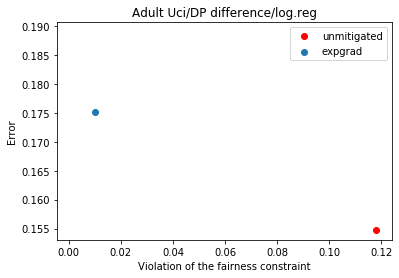

In [76]:
import matplotlib.pyplot as plt

plt.scatter(expgrad_violation_logistic,expgrad_error_logistic,label="expgrad")
plt.plot(violation_logistic,error_logistic,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

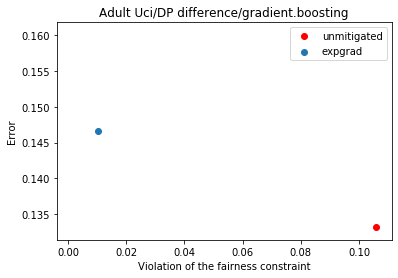

In [77]:
plt.scatter(expgrad_violation_ensemble,expgrad_error_ensemble,label="expgrad")
plt.plot(violation_ensemble,error_ensemble,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

# Grid Search for Logistic Learner

In [97]:
lambda_vecs_logistic = (expgrad_X_logistic._lambda_vecs_LP)
# print(lambda_vecs)
keys = lambda_vecs_logistic.keys()

lambda_vec_logistic = lambda_vecs_logistic[keys[-1]]
print(lambda_vec_logistic)

sign  event  group_id
+     all    0.0         0.000000
             1.0         0.000000
-     all    0.0         0.230375
             1.0         0.000000
Name: 6, dtype: float64


In [98]:
lambda_0_logistic = lambda_vec_logistic['+','all',0] - lambda_vec_logistic['-','all',0]
print(lambda_0_logistic)

-0.23037486952374486


In [105]:
scope = 0.5

lambda_multipliers_logistic = np.linspace(lambda_0_logistic-scope, lambda_0_logistic+scope, 31)


iterables = [['+', '-'], ['all'], [0,1]]
midx = pd.MultiIndex.from_product(iterables, names=['sign', 'event', 'group_id'])

new_lambdas = []
for l in lambda_multipliers_logistic:
    nxt = pd.Series(np.zeros(4), index=midx)
    
    if l < 0:
        nxt[("-", "all", 0)] = abs(l)
    else:
        nxt[("+", "all", 0)] = l

    new_lambdas.append(nxt)
multiplier_df_logistic = pd.concat(new_lambdas,axis=1)


In [106]:
grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=multiplier_df_logistic)
grid_search_logistic.fit(X_train, y_train, sensitive_features=A_train)

In [107]:
grid_search_logistic_y = pd.Series(grid_search_logistic.predict(X_train),name="grid_search_logistic_y")
grid_search_logistic_error = get_error(y_train,grid_search_logistic_y)
grid_search_logistic_violation = get_violation(grid_search_logistic_y,A_train,"grid_search_logistic_y")

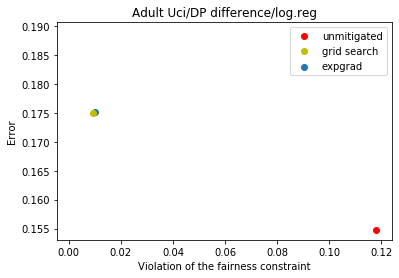

In [118]:
plt.scatter(expgrad_violation_logistic,expgrad_error_logistic,label="expgrad")
plt.plot(violation_logistic,error_logistic,'ro',label="unmitigated")
plt.plot(grid_search_logistic_violation,grid_search_logistic_error,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

# Grid Search for Gradient Boosting

In [103]:
lambda_vecs_ensemble = (expgrad_X_ensemble._lambda_vecs_LP)
# print(lambda_vecs)
keys = lambda_vecs_ensemble.keys()

lambda_vec_ensemble = lambda_vecs_ensemble[keys[-1]]
print(lambda_vec_ensemble)

sign  event  group_id
+     all    0.0         0.00000
             1.0         0.00000
-     all    0.0         0.30148
             1.0         0.00000
Name: 6, dtype: float64


In [104]:
lambda_0_ensemble = lambda_vec_ensemble['+','all',0] - lambda_vec_ensemble['-','all',0]
print(lambda_0_ensemble)

-0.30148036195106087


In [111]:
scope = 0.5

lambda_multipliers_ensemble = np.linspace(lambda_0_ensemble-scope, lambda_0_ensemble+scope, 31)


iterables = [['+', '-'], ['all'], [0,1]]
midx = pd.MultiIndex.from_product(iterables, names=['sign', 'event', 'group_id'])

new_lambdas = []
for l in lambda_multipliers_ensemble:
    nxt = pd.Series(np.zeros(4), index=midx)
    
    if l < 0:
        nxt[("-", "all", 0)] = abs(l)
    else:
        nxt[("+", "all", 0)] = l

    new_lambdas.append(nxt)
multiplier_df_ensemble = pd.concat(new_lambdas,axis=1)


In [113]:
grid_search_ensemble=GridSearch(GradientBoostingClassifier(),
                        constraints=DemographicParity(),
                        grid=multiplier_df_ensemble)
grid_search_ensemble.fit(X_train, y_train, sensitive_features=A_train)

In [114]:
grid_search_ensemble_y = pd.Series(grid_search_ensemble.predict(X_train),name="grid_search_ensemble_y")
grid_search_ensemble_error = get_error(y_train,grid_search_ensemble_y)
grid_search_ensemble_violation = get_violation(grid_search_ensemble_y,A_train,"grid_search_ensemble_y")

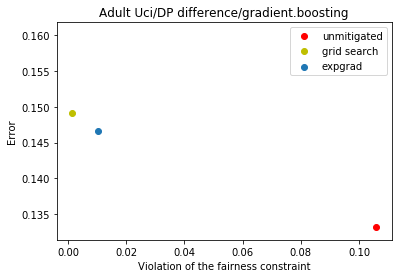

In [117]:
plt.scatter(expgrad_violation_ensemble,expgrad_error_ensemble,label="expgrad")
plt.plot(violation_ensemble,error_ensemble,'ro',label="unmitigated")
plt.plot(grid_search_ensemble_violation,grid_search_ensemble_error,'yo',label="grid search")

plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()